<a href="https://colab.research.google.com/github/mannam95/Deep_Learning_Programming/blob/main/Assignment4/IDL_Ass_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Team


1.   Govind Shukla (235192)
2.   Meghana Rao (234907)
3.   Srinath Mannam (229750)

#Imports

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import BatchNormalization
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
import numpy as np

#Data loading

170508288/170498071 [==============================] - 11s 0us/step
[6]


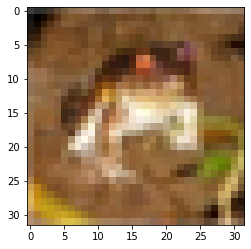

In [2]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()
print(train_labels[0])
plt.imshow(train_images[0])
plt.show()

def reset_data():
  train_data = tf.data.Dataset.from_tensor_slices(
      (train_images.astype(np.float32) / 255, train_labels.reshape(-1).astype(np.int32)))
  train_data = train_data.shuffle(buffer_size=60000).batch(128)

  test_data = tf.data.Dataset.from_tensor_slices(
      (test_images.astype(np.float32) / 255, test_labels.reshape(-1).astype(np.int32))).batch(128)
  return train_data, test_data

train_data, test_data = reset_data()

optimizer = tf.optimizers.Adam()
loss_fn = tf.losses.SparseCategoricalCrossentropy(from_logits=True)

# Prepare the metrics.
train_acc_metric = keras.metrics.SparseCategoricalAccuracy()

#Functions


$H$ represents a composite function which takes in an image/feature map ( $x$ ) and performs some operations on it. 

$ x \to Batch \ Normalization \to ReLU \to Zero \ Padding \to 3 \times 3 \ Convolution \ \to Dropout$

In [3]:

def H(inputs, num_filters , dropout_rate ):
    batchNorm = tf.keras.layers.BatchNormalization() ( inputs )
    relu = tf.keras.layers.Activation('relu')(batchNorm)
    zeropad = tf.keras.layers.ZeroPadding2D((1, 1))(relu)
    Conv2D_3_3 = tf.keras.layers.Conv2D(num_filters, kernel_size=(3, 3), use_bias=False , kernel_initializer='he_normal' )(zeropad)
    x = tf.keras.layers.Dropout(rate=dropout_rate )(Conv2D_3_3)
    return x


In [4]:
def transition(inputs, num_filters, dropout_rate ):

    batchNorm = tf.keras.layers.BatchNormalization()(inputs)
    relu = tf.keras.layers.Activation('relu')(batchNorm)

    Conv2D_bottleneck = tf.keras.layers.Conv2D( num_filters, kernel_size=(1, 1), padding='same' , 
                                               kernel_initializer='he_normal' ,
                                               kernel_regularizer=tf.keras.regularizers.l2( 1e-4 ) )(relu)
    dropOut = tf.keras.layers.Dropout(rate=dropout_rate)(Conv2D_bottleneck)
    
    avg = tf.keras.layers.AveragePooling2D(pool_size=(2, 2))(dropOut)
    return avg


In [5]:
def dense_block( inputs, num_layers, num_filters, growth_rate , dropout_rate ):
    for i in range(num_layers):
        conv_outputs = H(inputs, num_filters , dropout_rate )
        inputs = tf.keras.layers.Concatenate()([conv_outputs, inputs])
        num_filters += growth_rate # To increase the number of filters for each layer.
    return inputs, num_filters


In [6]:
def DenseModel(input_shape, num_blocks, num_layers_per_block, growth_rate, dropout_rate, num_filters, model_name):

  inputs = tf.keras.layers.Input( shape=input_shape)
  x = tf.keras.layers.Conv2D( num_filters , kernel_size=( 3 , 3 ) , kernel_initializer='he_normal' , kernel_regularizer=tf.keras.regularizers.l2( 1e-4 ) )( inputs )

  for i in range(num_blocks):
      x, num_filters = dense_block( x, num_layers_per_block , num_filters, growth_rate , dropout_rate )
      x = transition(x, num_filters , dropout_rate)

  flat = tf.keras.layers.Flatten()(x)
  logits = tf.keras.layers.Dense( 10 )( flat ) # Num Classes for CIFAR-10
  model = tf.keras.models.Model( inputs , logits, name = model_name)
  return model

In [7]:
def trainer_run(model, epochs, train_steps, train_data):
  start = time.time()
  for epoch in range(epochs):
    print("Epoch : ", epoch+1)
    for step, (image_batch, label_batch) in enumerate(train_data):

        with tf.GradientTape() as tape:
          logits = model(image_batch)
          loss = loss_fn(label_batch, logits)

        variables = model.trainable_variables
        gradients = tape.gradient(loss, variables)
          
        optimizer.apply_gradients(zip(gradients, variables))
        
        train_acc_metric(label_batch, logits)

        if not step % 1000:
            predictions = tf.argmax(logits, axis=1, output_type=tf.int32)
            print("Loss: {} Accuracy: {}".format(loss, train_acc_metric.result()))
            # Reset training metrics at the end of each epoch
            train_acc_metric.reset_states()

    stop = time.time()
    print("took {} seconds\n".format(stop-start))
    start = time.time()

In [8]:
# stereotypical train-step-with-function-annotation

@tf.function
def train_step(images, labels, model):
    with tf.GradientTape() as tape:
        logits = model(images)
        xent = tf.losses.SparseCategoricalCrossentropy(from_logits=True) (labels, logits)
    variables = model.trainable_variables
    gradients = tape.gradient(xent, variables)
    optimizer.apply_gradients(zip(gradients, variables))

    return xent, logits

In [9]:
def function_trainer_run(model, epochs, train_steps, train_data):
  start = time.time()
  train_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()
  loss_fn = tf.losses.SparseCategoricalCrossentropy(from_logits=True)
  for epoch in range(epochs):
    print("Epoch : ", epoch+1)
    for step, (img_batch, lbl_batch) in enumerate(train_data):

        if step > train_steps:
          break

        xent, logits = train_step(img_batch, lbl_batch, model)

        if not step % 1000:
            train_acc_metric(lbl_batch, logits)
            acc = train_acc_metric.result()
            print("Loss: {} Accuracy: {}".format(xent, acc))
            train_acc_metric.reset_states()

    stop = time.time()
    print("took {} seconds\n".format(stop-start))
    start = time.time()

In [10]:
def evaluate(model, test_data):
  test_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()
  print('----------------------Evaluation---------------------')
  for image_batch, label_batch in test_data:
      test_acc_metric(label_batch, model(image_batch))
  print("Test acc: {}".format(test_acc_metric.result()))

#Model_1

Model: "DenseModel_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_22 (Conv2D)             (None, 30, 30, 16)   448         ['input_4[0][0]']                
                                                                                                  
 batch_normalization_20 (BatchN  (None, 30, 30, 16)  64          ['conv2d_22[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_20 (Activation)     (None, 30, 30, 16)   0           ['batch_normalization_

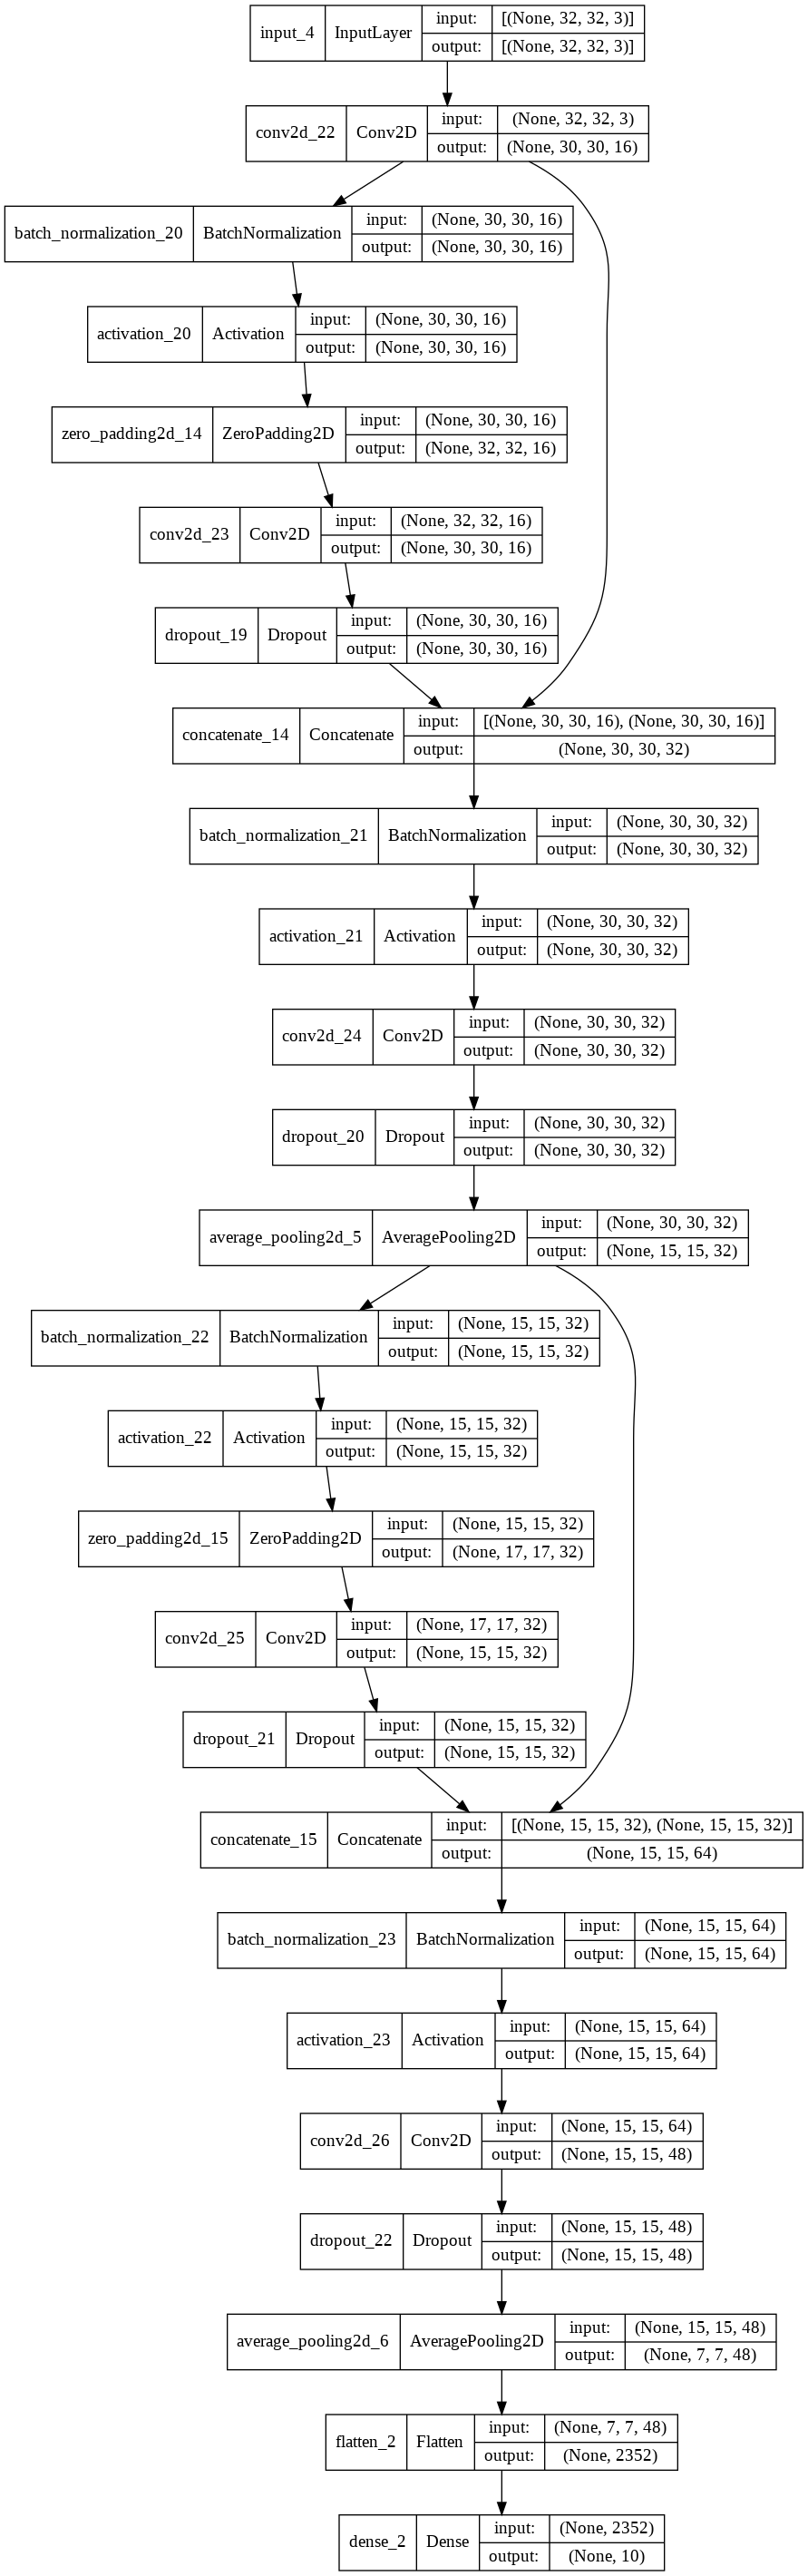

In [29]:
denseModel_1 = DenseModel(input_shape = ( 32 , 32 , 3 ),
                          num_blocks = 2,
                          num_layers_per_block = 1,
                          growth_rate = 16,
                          dropout_rate = 0.4,
                          num_filters = 16,
                          model_name = 'DenseModel_1')
denseModel_1.summary()
tf.keras.utils.plot_model( denseModel_1 , show_shapes=True )

In [30]:
trainer_run(denseModel_1, 25, 1000, train_data)
evaluate(denseModel_1, test_data)

Epoch :  1
Loss: 2.385561943054199 Accuracy: 0.1328125
took 12.823205947875977 seconds

Epoch :  2
Loss: 1.1660020351409912 Accuracy: 0.43452000617980957
took 12.524093627929688 seconds

Epoch :  3
Loss: 1.2832915782928467 Accuracy: 0.5728999972343445
took 12.640541315078735 seconds

Epoch :  4
Loss: 1.0374175310134888 Accuracy: 0.6246399879455566
took 12.57402753829956 seconds

Epoch :  5
Loss: 0.9873001575469971 Accuracy: 0.6517599821090698
took 12.687433958053589 seconds

Epoch :  6
Loss: 1.002352237701416 Accuracy: 0.6774200201034546
took 12.668872117996216 seconds

Epoch :  7
Loss: 0.8265969753265381 Accuracy: 0.6947199702262878
took 12.619171380996704 seconds

Epoch :  8
Loss: 0.9027705192565918 Accuracy: 0.707040011882782
took 12.422489643096924 seconds

Epoch :  9
Loss: 0.6134613752365112 Accuracy: 0.7213600277900696
took 12.681310653686523 seconds

Epoch :  10
Loss: 0.7574962973594666 Accuracy: 0.7310400009155273
took 12.663962364196777 seconds

Epoch :  11
Loss: 0.83040881156

In [31]:
denseModel_func_1 = DenseModel(input_shape = ( 32 , 32 , 3 ),
                          num_blocks = 2,
                          num_layers_per_block = 1,
                          growth_rate = 16,
                          dropout_rate = 0.4,
                          num_filters = 16,
                          model_name = 'denseModel_func_1')
train_data, test_data = reset_data()
function_trainer_run(denseModel_func_1, 25, 1000, train_data)
evaluate(denseModel_func_1, test_data)

Epoch :  1
Loss: 2.709336757659912 Accuracy: 0.0625
took 9.751818180084229 seconds

Epoch :  2
Loss: 1.4451053142547607 Accuracy: 0.5703125
took 8.439493417739868 seconds

Epoch :  3
Loss: 0.9745375514030457 Accuracy: 0.6484375
took 8.456024408340454 seconds

Epoch :  4
Loss: 1.0569565296173096 Accuracy: 0.6484375
took 8.466654300689697 seconds

Epoch :  5
Loss: 0.9068939089775085 Accuracy: 0.6875
took 8.454121351242065 seconds

Epoch :  6
Loss: 1.0414642095565796 Accuracy: 0.671875
took 8.479770183563232 seconds

Epoch :  7
Loss: 0.8285240530967712 Accuracy: 0.6953125
took 8.469413757324219 seconds

Epoch :  8
Loss: 0.808956503868103 Accuracy: 0.71875
took 8.454696893692017 seconds

Epoch :  9
Loss: 0.791271448135376 Accuracy: 0.7421875
took 8.478586673736572 seconds

Epoch :  10
Loss: 0.695806622505188 Accuracy: 0.7890625
took 8.457172632217407 seconds

Epoch :  11
Loss: 0.6750086545944214 Accuracy: 0.75
took 8.463199615478516 seconds

Epoch :  12
Loss: 0.7179865837097168 Accuracy: 0

#Model_2

Model: "DenseModel_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 30, 30, 16)   448         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 30, 30, 16)  64          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 30, 30, 16)   0           ['batch_normalization[

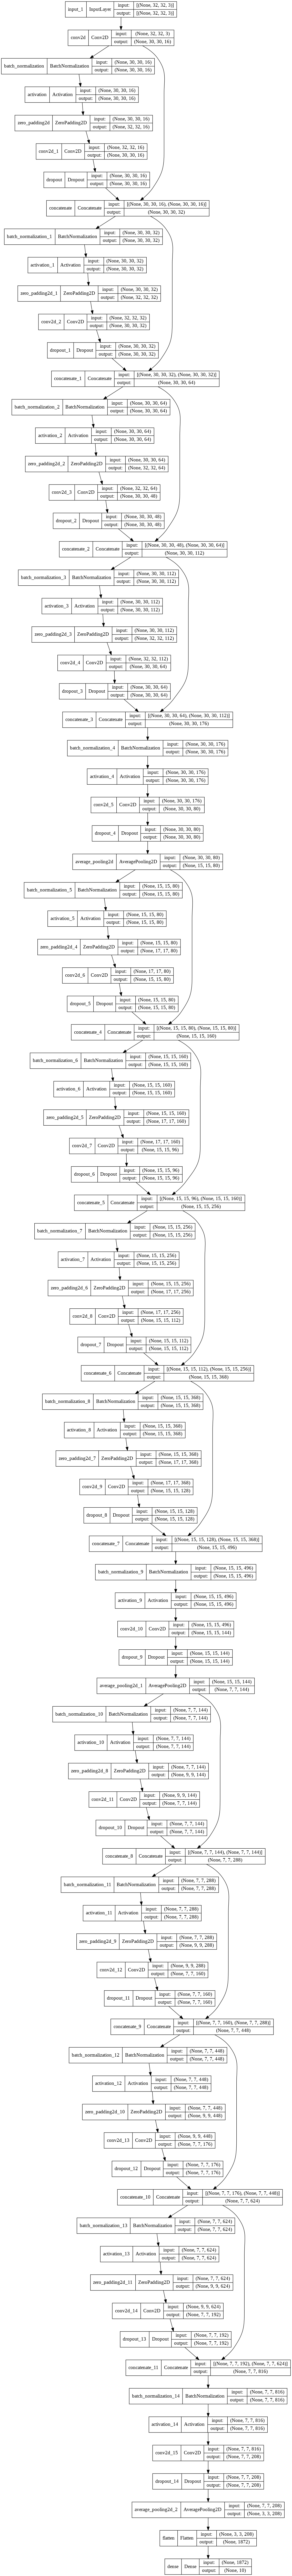

In [17]:
denseModel_2 = DenseModel(input_shape = ( 32 , 32 , 3 ),
                          num_blocks = 3,
                          num_layers_per_block = 4,
                          growth_rate = 16,
                          dropout_rate = 0.4,
                          num_filters = 16,
                          model_name = 'DenseModel_2')
denseModel_2.summary()
tf.keras.utils.plot_model( denseModel_2 , show_shapes=True )

In [33]:
trainer_run(denseModel_2, 25, 1000, train_data)
evaluate(denseModel_2, test_data)

Epoch :  1
Loss: 2.3323142528533936 Accuracy: 0.8144400119781494
took 96.75650835037231 seconds

Epoch :  2
Loss: 1.2313095331192017 Accuracy: 0.3574199974536896
took 96.64487147331238 seconds

Epoch :  3
Loss: 1.157350778579712 Accuracy: 0.5331599712371826
took 96.37594556808472 seconds

Epoch :  4
Loss: 1.009002447128296 Accuracy: 0.6186800003051758
took 96.26112532615662 seconds

Epoch :  5
Loss: 0.7396075129508972 Accuracy: 0.684719979763031
took 96.24105191230774 seconds

Epoch :  6
Loss: 0.5278617739677429 Accuracy: 0.7235599756240845
took 96.36069798469543 seconds

Epoch :  7
Loss: 0.5474417209625244 Accuracy: 0.7574800252914429
took 96.3177638053894 seconds

Epoch :  8
Loss: 0.6557225584983826 Accuracy: 0.7925599813461304
took 96.30159783363342 seconds

Epoch :  9
Loss: 0.4892444610595703 Accuracy: 0.8237199783325195
took 96.27307105064392 seconds

Epoch :  10
Loss: 0.3719746172428131 Accuracy: 0.8535799980163574
took 96.24470281600952 seconds

Epoch :  11
Loss: 0.2362488061189

In [37]:
denseModel_func_2 = DenseModel(input_shape = ( 32 , 32 , 3 ),
                          num_blocks = 3,
                          num_layers_per_block = 4,
                          growth_rate = 16,
                          dropout_rate = 0.4,
                          num_filters = 16,
                          model_name = 'denseModel_func_2')
train_data, test_data = reset_data()
function_trainer_run(denseModel_func_2, 3, 1000, train_data)
evaluate(denseModel_func_2, test_data)

Epoch :  1
Loss: 2.572618007659912 Accuracy: 0.078125
took 95.44534397125244 seconds

Epoch :  2
Loss: 1.5039080381393433 Accuracy: 0.375
took 91.75822281837463 seconds

Epoch :  3
Loss: 1.214695930480957 Accuracy: 0.5703125
took 91.92943406105042 seconds

----------------------Evaluation---------------------
Test acc: 0.6209999918937683


#Model with Data Augmentation

In [21]:

(train_cifar_images, train_cifar_labels), (test_cifar_images, test_cifar_labels) = tf.keras.datasets.cifar10.load_data()

train_cifar_labels = train_cifar_labels.reshape((-1,))
test_cifar_labels = test_cifar_labels.reshape((-1,))

train_cifar_images = train_cifar_images.astype(np.float32) / 255
train_cifar_labels = train_cifar_labels.astype(np.int32)

#Data Augmentation
datagen = ImageDataGenerator(rotation_range = 5, horizontal_flip = True, width_shift_range = 0.05, height_shift_range = 0.05, shear_range = 5)
datagen.fit(train_cifar_images)


train_cifar_data = tf.data.Dataset.from_tensor_slices((train_cifar_images, train_cifar_labels))
train_cifar_data = train_cifar_data.shuffle(buffer_size=60000).batch(128)

# note: we batch the test data, but do not shuffle/repeat
test_cifar_data = tf.data.Dataset.from_tensor_slices(
    (test_cifar_images.astype(np.float32) / 255, test_cifar_labels.astype(np.int32))).batch(128)

train_cifar_dataAug = datagen.flow(train_cifar_images, train_cifar_labels, batch_size=128)

optimizer = tf.optimizers.Adam()
loss_fn = tf.losses.SparseCategoricalCrossentropy(from_logits=True)

# Prepare the metrics.
train_acc_metric = keras.metrics.SparseCategoricalAccuracy()

In [ ]:
trainer_run(denseModel_2, 1, 1000, train_cifar_dataAug)
evaluate(denseModel_2, test_cifar_data)

Epoch :  1
Loss: 0.07962075620889664 Accuracy: 0.96875
Loss: 0.06335750222206116 Accuracy: 0.9646610021591187
Loss: 0.06186932325363159 Accuracy: 0.9680812954902649
Loss: 0.11662254482507706 Accuracy: 0.9700400233268738
Loss: 0.05848686024546623 Accuracy: 0.9718589782714844
Loss: 0.08621470630168915 Accuracy: 0.9738866686820984
Loss: 0.07976597547531128 Accuracy: 0.975073516368866
